In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

np.random.seed(0)


 # 1. Utility Functions

In [24]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Computes the sigmoid activation function element-wise.
    
    Parameters
    ----------
    x : np.ndarray
        Input array.
    
    Returns
    -------
    np.ndarray
        Sigmoid output, same shape as input.
    """
    return 1 / (1 + np.exp(-x))


def generate_synthetic_dataset(
    n_features: int = 4,
    pi: float = 0.5,
    cov_scale: float = 3.5,
    mean_shift_scale: float = 1.5,
    n_samples: int = 1000,
    random_seed: int = 0
):
    """
    Generates a synthetic dataset by mixing two n_features-dimensional
    Gaussian distributions:
      - distribution A with (mean0, cov0)
      - distribution B with (mean1, cov1)

    Mixture controlled by 'pi': fraction from distribution B vs. A.

    A label is generated by applying a random linear transformation followed by 
    a logistic (sigmoid) function: y = Bernoulli(sigmoid(X @ w)).

    Parameters
    ----------
    n_features : int, optional
        Dimensionality of the feature space, by default 3.
    pi : float, optional
        Probability of drawing from distribution B (vs A), by default 0.5.
    cov_scale : float, optional
        Scaling factor for the second distribution's covariance, by default 3.5.
    mean_shift_scale : float, optional
        Scaling factor for the second distribution's mean, by default 1.5.
    n_samples : int, optional
        Number of samples to generate, by default 1000.
    random_seed : int, optional
        Seed for reproducibility, by default 0.

    Returns
    -------
    (X, y) : (np.ndarray, np.ndarray)
        - X is of shape (n_samples, n_features)
        - y is of shape (n_samples,)
    """
    np.random.seed(random_seed)

   
    A = np.random.rand(n_features, n_features) * 10
    cov0 = A @ A.T  
    mean0 = np.random.uniform(5, 15, size=n_features)

    # Orthogonal transform for distribution B (shifted)
    random_ortho = ortho_group.rvs(dim=n_features)
    cov1 = random_ortho @ cov0 @ random_ortho.T
    cov1 *= cov_scale
    mean1 = mean0 * mean_shift_scale

    # Mixture selection. THE HIGHER PI THE MORE LIKELY TO DRAW FROM SHIFTED DISTRIBUTION  
    choices = np.random.choice([0, 1], size=n_samples, p=[1 - pi, pi])
    X = np.zeros((n_samples, n_features))

    for i in range(n_samples):
        if choices[i] == 0:
            X[i] = np.random.multivariate_normal(mean0, cov0)
        else:
            X[i] = np.random.multivariate_normal(mean1, cov1)

    
    weights = np.random.uniform(-0.5, 0.5, size=n_features)  # Generate random weights for label generation
    z = X @ weights
    probs = sigmoid(z)
    y = np.random.binomial(1, probs)

    return X, y


 # 2. Creating and Storing Shifted Datasets (Flexible n_features)

In [25]:
def create_shifted_datasets(
    n_features: int = 2, 
    output_folder: str = "generated_data",
    base_n_samples: int = 1000,
    cov_scale: float = 3.5,
    mean_shift_scale: float = 1.5
):
    """
    Creates multiple CSVs in `output_folder` for different pi values. 
    Each CSV contains [feature_0, ..., feature_{n_features-1}, target].
    
    Parameters
    ----------
    n_features : int, optional
        Dimensionality of generated data, by default 2.
    output_folder : str, optional
        Where to store generated CSVs, by default "generated_data".
    base_n_samples : int, optional
        Number of samples for each dataset, by default 1000.
    cov_scale : float, optional
        Scaling factor for the shifted distribution's covariance, by default 3.5.
    mean_shift_scale : float, optional
        Scaling factor for the shifted distribution's mean, by default 1.5.
    """
    os.makedirs(output_folder, exist_ok=True)
    
    
    X_orig, y_orig = generate_synthetic_dataset(            # "original" data: fix pi=0 => everything from distribution A (no shift)
        n_features=n_features,
        pi=0.0, 
        cov_scale=1.0, 
        mean_shift_scale=1.0, 
        n_samples=base_n_samples
    )
    columns = [f'feature_{i}' for i in range(n_features)]
    df_orig = pd.DataFrame(X_orig, columns=columns)
    df_orig['target'] = y_orig
    df_orig.to_csv(os.path.join(output_folder, 'original.csv'), index=False)
    
    
    pi_values = [0.1,0.3, 0.5, 0.7, 0.9]
    for pi in pi_values:                                # Creating multiple "shifted" versions with different pi
        X_shift, y_shift = generate_synthetic_dataset(
            n_features=n_features,
            pi=pi, 
            cov_scale=cov_scale, 
            mean_shift_scale=mean_shift_scale, 
            n_samples=base_n_samples
        )
        df_shift = pd.DataFrame(X_shift, columns=columns)
        df_shift['target'] = y_shift
        df_shift.to_csv(os.path.join(output_folder, f'shifted_{pi}.csv'), index=False)


 ### Example: Create 2D shift data

In [26]:
#create_shifted_datasets(n_features=4, output_folder="data_folder", base_n_samples=1000)


 # 3. Visualization for n-Dimensional Data



 For higher dimensional data (n > 2), we can either:

 - Visualize a pairwise scatter matrix (e.g., `sns.pairplot`) for a subset of features.

 - Or just visualize a specified pair of features for a quick glimpse.

In [27]:
def visualize_feature_shifts(
    folder: str = "data_folder",
    features_to_plot: tuple = (0, 1)
):
    """
    Plots distributions for 'original.csv' vs. each 'shifted_*.csv' file.
    Because data can be high-dimensional, we only plot two chosen dimensions 
    for scatter. For histograms, we also only plot these two selected features.

    Parameters
    ----------
    folder : str, optional
        The folder containing 'original.csv' and 'shifted_*.csv'.
    features_to_plot : tuple, optional
        Which two feature indices to visualize in scatter/hist, by default (0,1).
    """
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]
    original_file = [f for f in files if "original.csv" in f]
    
    if len(original_file) == 0:
        print("No original.csv found!")
        return
    
    # Load original
    df_orig = pd.read_csv(os.path.join(folder, original_file[0]))
    feat0, feat1 = features_to_plot
    col0, col1 = f"feature_{feat0}", f"feature_{feat1}"
    
    # Identify shifted files
    shifted_files = [f for f in files if "shifted_" in f]
    
    # 1) 2D Scatter 
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df_orig[col0], df_orig[col1],
        alpha=0.3, label='Original'
    )
    
    for sf in sorted(shifted_files):
      df_s = pd.read_csv(os.path.join(folder, sf))
      plt.scatter(
        df_s[col0], df_s[col1],
        alpha=0.3, label=sf
      )
    plt.legend()
    plt.title(f"Scatterplot: Original vs. Shifted [Features {feat0} & {feat1}]")
    plt.xlabel(col0)
    plt.ylabel(col1)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    
    for sf in sorted(shifted_files):
        df_s = pd.read_csv(os.path.join(folder, sf))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)        # 2) Histograms for these 2 features
        
        sns.histplot(
            df_orig[col0], color="blue", alpha=0.4, ax=axes[0], 
            label='Orig '+col0, kde=True
        )
        sns.histplot(
            df_s[col0], color="red", alpha=0.4, ax=axes[0], 
            label=sf+" "+col0, kde=True
        )
        axes[0].set_title(f"Distribution of {col0}")
        axes[0].legend()
        
        sns.histplot(
            df_orig[col1], color="blue", alpha=0.4, ax=axes[1], 
            label='Orig '+col1, kde=True
        )
        sns.histplot(
            df_s[col1], color="red", alpha=0.4, ax=axes[1], 
            label=sf+" "+col1, kde=True
        )
        axes[1].set_title(f"Distribution of {col1}")
        axes[1].legend()
        
        plt.suptitle(f"Feature Distributions Comparison: {sf}")
        plt.show()


 ### Example Visualization

In [28]:
#visualize_feature_shifts("data_folder", features_to_plot=(2,3))


 # 4. Baseline Model Evaluation Across Shifts (General n_features)

In [29]:
# TODO: search for the best hyperparameters for the models


def evaluate_models_on_shifts(folder: str = "data_folder"): 
    """
    1) Train a DecisionTree and a GradientBoosting model on 'original.csv'.
    2) Evaluate each model on all 'shifted_*' CSVs in the folder.
    3) Print metrics (Accuracy, F1, AUC) and plot ROC curves.

    Parameters
    ----------
    folder : str, optional
        Folder containing 'original.csv' and 'shifted_*.csv'.
    """
    # Load original => train data
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    
    # Fit Decision Tree
    dtc = DecisionTreeClassifier(max_depth=4, min_samples_leaf=13)
    dtc.fit(X_train, y_train)
    
    # Fit GradientBoosting
    gbc = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc.fit(X_train, y_train)
    
    # Evaluate on shifted sets
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    
    plt.figure(figsize=(10,5))
    color_map = {"DecisionTree": "blue", "GradientBoosting": "red"}
    
    for model, name in zip([dtc, gbc], ["DecisionTree", "GradientBoosting"]):
        color = color_map[name]
        for test_file in sorted(test_files):
            df_test = pd.read_csv(os.path.join(folder, test_file))
            X_test = df_test[X_train.columns]
            y_test = df_test['target']
            
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            acc = accuracy_score(y_test, y_pred)
            f1_ = f1_score(y_test, y_pred)
            auc_ = roc_auc_score(y_test, y_pred_proba)
            
            print(f"=== {name} on {test_file} ===")
            print(f"Accuracy: {acc:.3f}, F1: {f1_:.3f}, AUC: {auc_:.3f}")
            print(classification_report(y_test, y_pred))
            print("---------------------------------------------------")
            
            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            label_str = f"{name}-{test_file} (AUC={auc_:.3f})"
            plt.plot(fpr, tpr, label=label_str, color=color, alpha=0.3)
    
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves on Shifted Test Sets")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


 ### Example Baseline Evaluation

In [30]:
#evaluate_models_on_shifts("data_folder")

 # 5. Adversarial Training for GradientBoosting (General n_features)

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

def generate_adversarial_samples_gbc(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    epsilon: float = 0.1,
    max_rounds: int = 3,
    fraction_to_perturb: float = 0.5,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Improved adversarial sample generator.
    - We do multiple smaller steps (up to max_rounds).
    - Each round we only perturb a subset (fraction_to_perturb) of samples
      (e.g., those with the highest model confidence or chosen randomly).
    - We apply a smaller shift epsilon in each round.
    
    Parameters
    ----------
    model : fitted classifier with predict_proba
    X : pd.DataFrame
        Original features (n_samples, n_features).
    y : pd.Series
        True labels.
    epsilon : float
        Base step size for each round.
    max_rounds : int
        Number of small-shift rounds to perform.
    fraction_to_perturb : float
        Fraction of samples to adversarially perturb each round.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    X_adv : pd.DataFrame
        Adversarially perturbed features, same shape as X but with partial modifications.
    """
    rng = np.random.RandomState(random_state)
    X_adv = X.copy()
    
    for _ in range(max_rounds):
        # Possibly pick the subset of samples to perturb
        n_samples = len(X_adv)
        subset_size = int(fraction_to_perturb * n_samples)
        
        # Example strategy: pick the samples where the model is most confident
        # OR randomly pick subset. Here we do random for simplicity:
        indices_to_perturb = rng.choice(n_samples, size=subset_size, replace=False)
        
        for i in indices_to_perturb:
            x_i = X_adv.iloc[i].values.copy()
            true_label = y.iloc[i]
            
            # For each feature, do small +/- delta checks
            for feat_idx in range(len(x_i)):
                x_i_pos = x_i.copy()
                x_i_neg = x_i.copy()
                x_i_pos[feat_idx] += 1e-3
                x_i_neg[feat_idx] -= 1e-3
                df_x_i_pos = pd.DataFrame(x_i_pos.reshape(1, -1), columns=X.columns)
                df_x_i_neg = pd.DataFrame(x_i_neg.reshape(1, -1), columns=X.columns)
                prob_pos = model.predict_proba(df_x_i_pos)[0][true_label]
                prob_neg = model.predict_proba(df_x_i_neg)[0][true_label]
                
                grad_est = (prob_pos - prob_neg) / (2e-3)
                # Move in direction that *lowers* probability of the correct label
                direction = -1 if grad_est > 0 else 1
                # Smaller step
                x_i[feat_idx] += direction * epsilon
            
            X_adv.iloc[i] = x_i
            
        # Optional: re-fit the model incrementally, or we can do a single re-fit outside
        # For demonstration, let's do a single final re-fit outside this function
    return X_adv


def adversarial_training_gbc(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    base_model=None,
    epsilon: float = 0.1,
    max_rounds: int = 3,
    fraction_to_perturb: float = 0.5,
    final_train_size: int = None,
    random_state: int = 42
):
    """
    1) Fit the base_model (or default GB) on (X_train, y_train).
    2) Generate improved adversarial samples in multiple small steps.
    3) Augment the dataset -> (X_aug, y_aug).
    4) Downsample to final_train_size (to ensure same #samples as baseline).
    5) Retrain a new model on the final augmented set.
    """
    if base_model is None:
        base_model = GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=4,
            max_features='log2',
            min_samples_leaf=13,
            n_estimators=100,
            subsample=0.7,
            random_state=random_state
        )
    
    # 1) Fit the initial model
    base_model.fit(X_train, y_train)
    
    # 2) Generate adversarial samples (multiple smaller shifts)
    X_adv = generate_adversarial_samples_gbc(
        model=base_model,
        X=X_train,
        y=y_train,
        epsilon=epsilon,
        max_rounds=max_rounds,
        fraction_to_perturb=fraction_to_perturb,
        random_state=random_state
    )
    y_adv = y_train.copy()  # same labels
    
    # 3) Augment dataset
    X_aug = pd.concat([X_train, X_adv], ignore_index=True)
    y_aug = pd.concat([y_train, y_adv], ignore_index=True)
    
    # 4) Downsample to final_train_size if needed
    rng = np.random.RandomState(random_state)
    if final_train_size is not None and final_train_size < len(X_aug):
        indices = rng.choice(len(X_aug), size=final_train_size, replace=False)
        X_aug = X_aug.iloc[indices].reset_index(drop=True)
        y_aug = y_aug.iloc[indices].reset_index(drop=True)
    
    # 5) Retrain final model
    adv_model = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7,
        random_state=random_state
    )
    adv_model.fit(X_aug, y_aug)
    
    return adv_model, X_aug, y_aug


 ### Compare Normal vs. Adversarial Training on Shifted Sets

In [32]:
def compare_adversarial_training(folder: str = "data_folder"):
    """
    Demonstrates the effect of adversarial training:
      1) Train a normal GradientBoosting on original.csv.
      2) Train an adversarially-augmented GradientBoosting on the same dataset.
      3) Compare performance on each shifted dataset.
    """
    # 1) Load original => train data
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    
    # Normal GBC
    gbc_normal = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc_normal.fit(X_train, y_train)
    
    # Adversarial training
    gbc_adversarial, _, _ = adversarial_training_gbc(
        X_train, y_train, 
        epsilon=0.2, 
        
    )
    
    # 2) Evaluate on shifted sets
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    
    print("\n=== Evaluate Normal GBC vs. Adversarial GBC on Shifted Data ===\n")
    for test_file in sorted(test_files):
        df_test = pd.read_csv(os.path.join(folder, test_file))
        X_test = df_test[X_train.columns]
        y_test = df_test['target']
        
        # Normal
        y_pred_n = gbc_normal.predict(X_test)
        y_proba_n = gbc_normal.predict_proba(X_test)[:, 1]
        acc_n = accuracy_score(y_test, y_pred_n)
        f1_n = f1_score(y_test, y_pred_n)
        auc_n = roc_auc_score(y_test, y_proba_n)
        
        # Adversarial
        y_pred_a = gbc_adversarial.predict(X_test)
        y_proba_a = gbc_adversarial.predict_proba(X_test)[:, 1]
        acc_a = accuracy_score(y_test, y_pred_a)
        f1_a = f1_score(y_test, y_pred_a)
        auc_a = roc_auc_score(y_test, y_proba_a)
        
        print(f"Shifted file: {test_file}")
        print(f"  Normal GBC => Acc: {acc_n:.3f}, F1: {f1_n:.3f}, AUC: {auc_n:.3f}")
        print(f"  AdvTrain GBC => Acc: {acc_a:.3f}, F1: {f1_a:.3f}, AUC: {auc_a:.3f}")
        print("---------------------------------------------------")


In [33]:
#compare_adversarial_training("data_folder")

 # 6. Mechanistic-Interpretability-Guided Robust Boosting

In [34]:
def mech_interp_boosting(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    base_model=None,
    base_shift_factor: float = 0.1,
    n_rounds: int = 2,
    fraction_to_shift: float = 0.3,
    min_improvement: float = 0.001,
    noise_scale: float = 0.01,
    n_features_to_shift: int = 1,
    final_train_size: int = None,
    use_weighted_fit: bool = False,
    random_state: int = 42
):
    """
    Improved Mechanistic-Interpretability-Guided Robust Boosting.
    
    Changes:
      1) Per-round, only shift a fraction of samples (fraction_to_shift).
      2) Weighted training (optional): shift data can have a higher sample_weight, 
         so the model doesn't need an even bigger dataset but still focuses on them.
      3) Repeated smaller shift_factor, combined with early stopping on a validation set.
      4) Final downsampling to ensure fair #samples vs. baseline.

    Parameters
    ----------
    X_train, y_train : pd.DataFrame, pd.Series
        Original data
    base_model : fitted or None
        If None, a new GradientBoostingClassifier is created.
    base_shift_factor : float
        Initial magnitude of shift for the selected features.
    n_rounds : int
        Max number of augmentation rounds.
    fraction_to_shift : float
        Fraction of samples to shift each round.
    min_improvement : float
        Minimum improvement in validation for continuing rounds.
    noise_scale : float
        Std dev of random noise added to each shifted sample.
    n_features_to_shift : int
        # of top features to shift.
    final_train_size : int or None
        If not None, downsample the final augmented set to this size.
    use_weighted_fit : bool
        If True, we apply sample weights that are higher for newly shifted samples.
    random_state : int
        Reproducibility seed.

    Returns
    -------
    model : GradientBoostingClassifier
        The final robust model after all rounds.
    X_final, y_final : final training set used to fit (with or without weighting).
    """
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split

    rng = np.random.RandomState(random_state)
    
    if base_model is None:
        base_model = GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=4,
            max_features='log2',
            min_samples_leaf=13,
            n_estimators=100,
            subsample=0.7,
            random_state=random_state
        )

    # Train/Val split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state
    )

    # This is the growing augmented set
    X_aug = X_tr.copy()
    y_aug = y_tr.copy()
    # (optional) Keep track of sample weights
    sample_weights = np.ones(len(X_aug))  # default weight=1

    best_val_score = 0.0
    rounds_without_improvement = 0
    
    for round_idx in range(n_rounds):
        # Fit the model with or without weighting
        if use_weighted_fit:
            base_model.fit(X_aug, y_aug, sample_weight=sample_weights)
        else:
            base_model.fit(X_aug, y_aug)
        
        val_score = base_model.score(X_val, y_val)
        print(f"[Round {round_idx+1}] Validation Score = {val_score:.3f}")

        # Early stopping check
        if val_score > best_val_score + min_improvement:
            best_val_score = val_score
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
            if rounds_without_improvement >= 3:
                print(f"Early stopping at round {round_idx+1}")
                break

        # SHIFT SAMPLES:
        # Only shift fraction_to_shift portion of the data
        n_current = len(X_aug)
        subset_size = int(fraction_to_shift * n_current)
        idx_to_shift = rng.choice(n_current, size=subset_size, replace=False)
        
        shift_list = []
        label_list = []
        weight_list = []

        current_shift_factor = base_shift_factor * (0.9 ** round_idx)
        
        #print("ciao")
        
        for i in idx_to_shift:
            
            x_i = X_aug.iloc[i].values.copy()
            label_i = y_aug.iloc[i]
            
            # Compute approximate gradient-based feature importance
            # Probability of correct label
            df_x_i = pd.DataFrame(x_i.reshape(1, -1), columns=X_tr.columns)
            prob_original = base_model.predict_proba(df_x_i)[0][label_i]

            feature_scores = []
            for feat_idx in range(len(x_i)):
                x_pos = x_i.copy()
                x_neg = x_i.copy()
                x_pos[feat_idx] += 1e-3
                x_neg[feat_idx] -= 1e-3
                df_x_pos = pd.DataFrame(x_pos.reshape(1, -1), columns=X_tr.columns)
                df_x_neg = pd.DataFrame(x_neg.reshape(1, -1), columns=X_tr.columns)
                prob_pos = base_model.predict_proba(df_x_pos)[0][label_i]
                prob_neg = base_model.predict_proba(df_x_neg)[0][label_i]
                grad_est = (prob_pos - prob_neg) / (2e-3)
                feature_scores.append(abs(grad_est))
            
            top_feats = np.argsort(feature_scores)[-n_features_to_shift:]
            
            shift_dir = np.zeros_like(x_i)
            for feat_idx in top_feats:
                # Recompute sign(grad) to see which direction lowers prob
                x_pos[feat_idx] = x_i[feat_idx] + 1e-3
                x_neg[feat_idx] = x_i[feat_idx] - 1e-3
                df_x_pos = pd.DataFrame(x_pos.reshape(1, -1), columns=X_tr.columns)
                df_x_neg = pd.DataFrame(x_neg.reshape(1, -1), columns=X_tr.columns)
                prob_pos = base_model.predict_proba(df_x_pos)[0][label_i]
                prob_neg = base_model.predict_proba(df_x_neg)[0][label_i]
                actual_grad = (prob_pos - prob_neg) / (2e-3)
                direction_sign = -1 if actual_grad > 0 else 1
                shift_dir[feat_idx] = direction_sign
            noise = rng.normal(0, noise_scale, size=len(x_i))
            x_shifted = x_i + shift_dir * current_shift_factor + noise
            
            shift_list.append(x_shifted)
            label_list.append(label_i)
            if use_weighted_fit:
                # e.g., give a slightly higher weight, so model focuses on these new shifted points
                weight_list.append(2.0)  # shift points weight=2.0
            else:
                weight_list.append(1.0)

        # Augment
        df_shifted = pd.DataFrame(shift_list, columns=X_tr.columns)
        s_labels = pd.Series(label_list, name='target')
        
        X_aug = pd.concat([X_aug, df_shifted], ignore_index=True)
        y_aug = pd.concat([y_aug, s_labels], ignore_index=True)
        if use_weighted_fit:
            sample_weights = np.concatenate([sample_weights, np.array(weight_list)])
        else:
            # Keep same weighting for original samples
            sample_weights = np.ones(len(X_aug))

        print(f"  => Added {len(df_shifted)} new shifted samples; total = {len(X_aug)}")

    # Final training set: combine with X_val
    X_final = pd.concat([X_aug, X_val], ignore_index=True)
    y_final = pd.concat([y_aug, y_val], ignore_index=True)

    final_weights = None
    if use_weighted_fit:
        # For simplicity, assume new samples from X_val have weight=1
        w_val = np.ones(len(X_val))
        final_weights = np.concatenate([sample_weights, w_val])
    
    # Downsample to final_train_size
    if final_train_size is not None and final_train_size < len(X_final):
        indices = rng.choice(len(X_final), size=final_train_size, replace=False)
        X_final = X_final.iloc[indices].reset_index(drop=True)
        y_final = y_final.iloc[indices].reset_index(drop=True)
        if final_weights is not None:
            final_weights = final_weights[indices]

    # Final fit
    if use_weighted_fit:
        base_model.fit(X_final, y_final, sample_weight=final_weights)
    else:
        base_model.fit(X_final, y_final)

    return base_model, X_final, y_final


 ### Demo of Mechanistic Boosting on Shifted Data

In [35]:
def demo_mechanistic_robust_boosting(folder: str = "data_folder", n_rounds: int = 1):
    """
    Demonstrates the Mechanistic-Interpretability-Guided Robust Boosting 
    approach on 'original.csv' and evaluates it on the shifted CSV files.
    
    Parameters
    ----------
    folder : str, optional
        The folder containing 'original.csv' and 'shifted_*.csv'.
    n_rounds : int, optional
        How many augmentation+retrain rounds to run.
    """
    # 1) Load training data
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    
    # 2) Baseline GBC for comparison
    gbc_baseline = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc_baseline.fit(X_train, y_train)
    
    # 3) Mechanistic interpretability-based boosting
    gbc_mi, X_aug, y_aug = mech_interp_boosting(
        X_train, 
        y_train,
        #model=None,
        base_shift_factor=0.2,
        n_rounds=n_rounds,
        min_improvement=0.001,
        noise_scale=0.01,
        n_features_to_shift= 4
    )
    
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    print(f"\n=== Evaluate Baseline GBC vs. MI-Guided GBC (n_rounds={n_rounds}) on Shifted Data ===\n")
    
    for test_file in test_files:
        df_test = pd.read_csv(os.path.join(folder, test_file))
        X_test = df_test[X_train.columns]
        y_test = df_test['target']
        
        y_pred_b = gbc_baseline.predict(X_test)
        y_proba_b = gbc_baseline.predict_proba(X_test)[:, 1]
        acc_b = accuracy_score(y_test, y_pred_b)
        f1_b = f1_score(y_test, y_pred_b)
        auc_b = roc_auc_score(y_test, y_proba_b)
        
        
        y_pred_m = gbc_mi.predict(X_test)
        y_proba_m = gbc_mi.predict_proba(X_test)[:, 1]
        acc_m = accuracy_score(y_test, y_pred_m)
        f1_m = f1_score(y_test, y_pred_m)
        auc_m = roc_auc_score(y_test, y_proba_m)
        
        print(f"Shifted file: {test_file}")
        print(f"  Baseline GBC => Acc: {acc_b:.3f}, F1: {f1_b:.3f}, AUC: {auc_b:.3f}")
        print(f"  MI-Guided GBC => Acc: {acc_m:.3f}, F1: {f1_m:.3f}, AUC: {auc_m:.3f}")
        print("---------------------------------------------------")



In [36]:
demo_mechanistic_robust_boosting("data_folder", n_rounds=3)

[Round 1] Validation Score = 0.980
  => Added 240 new shifted samples; total = 1040
[Round 2] Validation Score = 0.980
  => Added 312 new shifted samples; total = 1352
[Round 3] Validation Score = 0.975
  => Added 405 new shifted samples; total = 1757

=== Evaluate Baseline GBC vs. MI-Guided GBC (n_rounds=3) on Shifted Data ===

Shifted file: shifted_06.csv
  Baseline GBC => Acc: 0.715, F1: 0.656, AUC: 0.828
  MI-Guided GBC => Acc: 0.715, F1: 0.656, AUC: 0.834
---------------------------------------------------
Shifted file: shifted_09.csv
  Baseline GBC => Acc: 0.960, F1: 0.953, AUC: 0.990
  MI-Guided GBC => Acc: 0.962, F1: 0.955, AUC: 0.967
---------------------------------------------------
Shifted file: shifted_08.csv
  Baseline GBC => Acc: 0.765, F1: 0.693, AUC: 0.861
  MI-Guided GBC => Acc: 0.768, F1: 0.696, AUC: 0.857
---------------------------------------------------
Shifted file: shifted_05.csv
  Baseline GBC => Acc: 0.641, F1: 0.538, AUC: 0.795
  MI-Guided GBC => Acc: 0.642,

In [37]:
def train_baseline_gb(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    final_train_size: int = None,
    random_state: int = 42
):
    """
    Train a standard GradientBoosting on exactly 'final_train_size' points 
    (if provided). If final_train_size < len(X_train), downsample first.
    """
    import numpy as np
    from sklearn.ensemble import GradientBoostingClassifier

    rng = np.random.RandomState(random_state)
    
    if final_train_size is not None and final_train_size < len(X_train):
        indices = rng.choice(len(X_train), size=final_train_size, replace=False)
        X_train = X_train.iloc[indices].reset_index(drop=True)
        y_train = y_train.iloc[indices].reset_index(drop=True)
    
    model = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model


 # 7. Compare All Models: Original, Adversarial, Mechanistic

In [38]:
def compare_models_performance(folder: str = "data_folder"):
    """
    Compare performance between:
      - Original Gradient Boosting
      - Adversarially Trained Gradient Boosting
      - Mechanistically-Interpreted (MI) Model
      
    Plots side-by-side bar charts of Accuracy, F1, AUC for each shifted dataset.
    """
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']

    final_size = len(X_train)
    gbc_original = train_baseline_gb(X_train, y_train, final_train_size=final_size)
    
    gbc_adversarial, X_adv, y_adv = adversarial_training_gbc(
        X_train, y_train,
        epsilon=0.1,
        max_rounds=3,
        fraction_to_perturb=0.5,
        final_train_size=final_size
    )
    
    gbc_mech, X_mi, y_mi = mech_interp_boosting(
        X_train, y_train,
        base_shift_factor=0.1,
        n_rounds=3,
        fraction_to_shift=0.7,
        use_weighted_fit=True,
        final_train_size=final_size
    )

    # Evaluate these three models on all shifted CSVs
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    test_files = sorted([f for f in os.listdir(folder) if f.startswith("shifted_")], 
               key=lambda x: int(x.split('_')[1].split('.')[0]))
    results = []
    model_dict = {
        "OriginalGB": gbc_original,
        "AdversarialGB": gbc_adversarial,
        "MechInterpGB": gbc_mech
    }

    for model_name, model_obj in model_dict.items():
        for test_file in test_files:
            df_test = pd.read_csv(os.path.join(folder, sorted(test_files)[test_files.index(test_file)]))
            X_test = df_test[X_train.columns]
            y_test = df_test['target']

            y_pred = model_obj.predict(X_test)
            y_pred_proba = model_obj.predict_proba(X_test)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            f1_ = f1_score(y_test, y_pred)
            auc_ = roc_auc_score(y_test, y_pred_proba)

            results.append({
                "Model": model_name,
                "ShiftedFile": test_file,
                "Accuracy": acc,
                "F1": f1_,
                "AUC": auc_
            })

    df_results = pd.DataFrame(results)
    metrics_to_plot = ["Accuracy", "F1", "AUC"]
    
    # Updated plotting code with fixed legends
    fig1, axes1 = plt.subplots(3, 1, figsize=(10, 15))
    
    for idx, metric in enumerate(metrics_to_plot):
        sns.barplot(
            data=df_results, 
            x="ShiftedFile", 
            y=metric, 
            hue="Model",
            ax=axes1[idx]
        )
        axes1[idx].set_title(f"{metric} Comparison")
        #axes1[idx].set_xticklabels(
        #    axes1[idx].get_xticklabels(), 
        #    rotation=45, 
        #    ha='right'
        #)
        #axes1[idx].set_ylim(0, 1.05)
        axes1[idx].legend(title="Models")
        
    plt.tight_layout()
    plt.show()

    fig2, axes2 = plt.subplots(3, 1, figsize=(10, 15))
    
    for idx, metric in enumerate(metrics_to_plot):
        pivot_data = df_results.pivot(
            index='ShiftedFile', 
            columns='Model', 
            values=metric
        )
        
        rel_improvement = 100 * (
            pivot_data - pivot_data['OriginalGB'].values.reshape(-1,1)
        ) / pivot_data['OriginalGB'].values.reshape(-1,1)
        
        # Explicitly set labels for legend
        rel_improvement_plot = rel_improvement[['AdversarialGB', 'MechInterpGB']].reset_index()
        rel_improvement_plot = pd.melt(
            rel_improvement_plot, 
            id_vars=['ShiftedFile'],
            var_name='Model',
            value_name='Improvement'
        )
        
        sns.barplot(
            data=rel_improvement_plot,
            x='ShiftedFile',
            y='Improvement',
            hue='Model',
            ax=axes2[idx]
        )
        
        axes2[idx].set_title(f'Relative {metric} Improvement (%)')
        axes2[idx].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        #axes2[idx].set_xticklabels(
        #    axes2[idx].get_xticklabels(), 
        #    rotation=45,
        #    ha='right'
        #)
        axes2[idx].set_ylabel('Improvement %')
        axes2[idx].legend(title="Models")
        
    plt.tight_layout()
    plt.show()


In [39]:
#compare_models_performance("data_folder")

# ONE CELL TO RUN THEM ALL

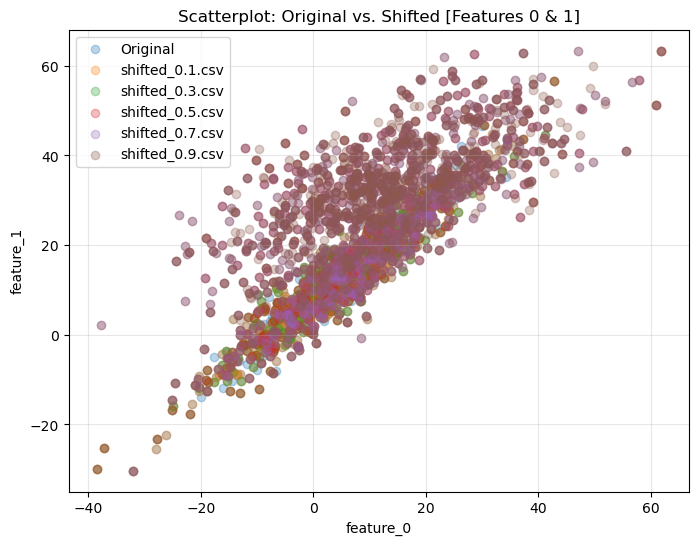

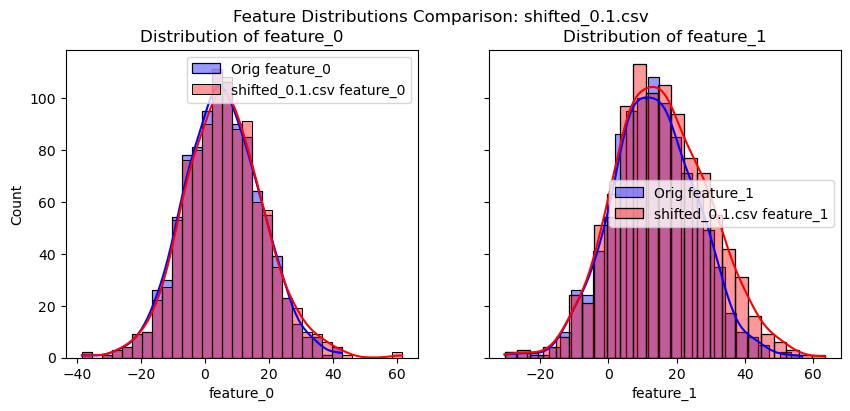

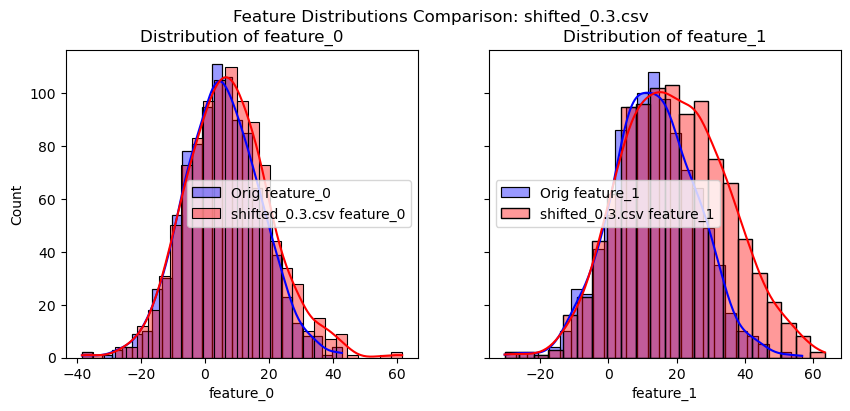

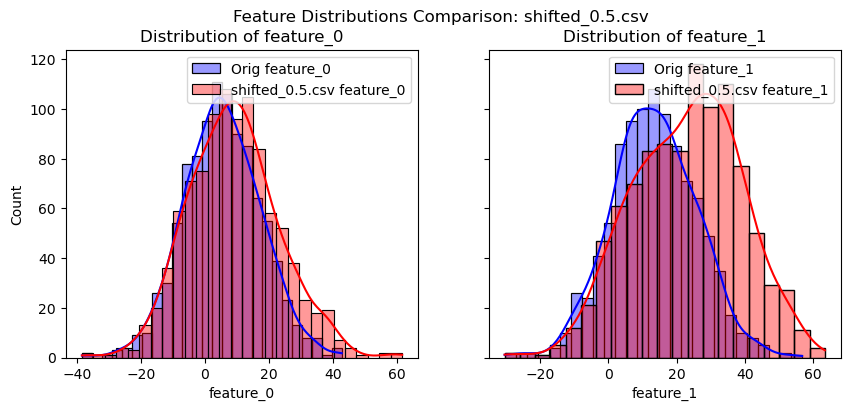

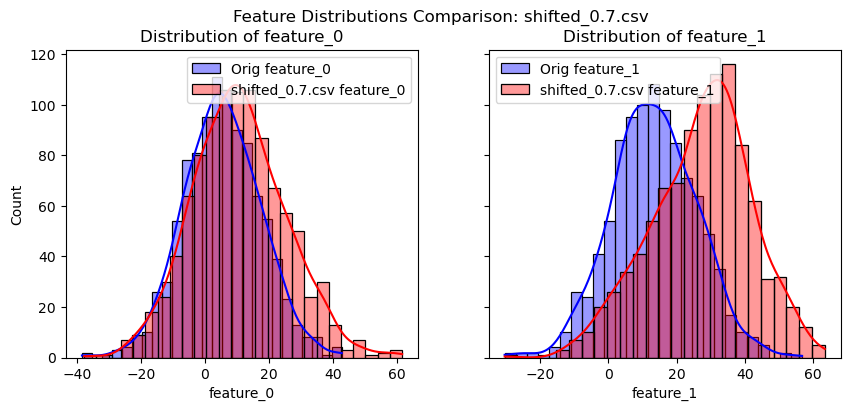

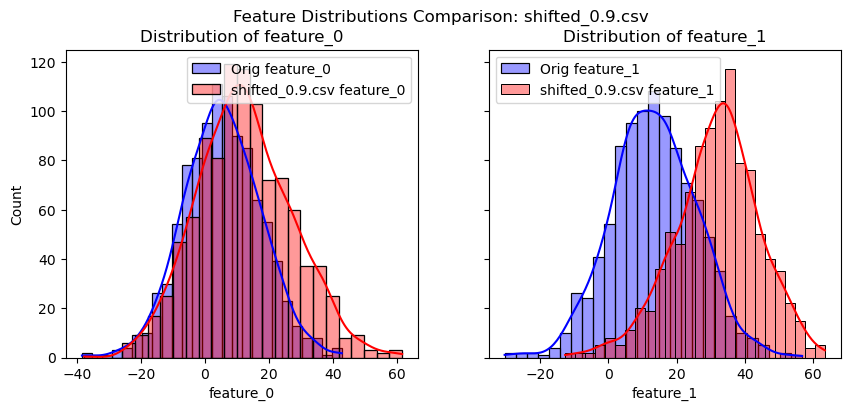

=== DecisionTree on shifted_0.1.csv ===
Accuracy: 0.979, F1: 0.930, AUC: 0.994
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       850
           1       0.93      0.93      0.93       150

    accuracy                           0.98      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.98      0.98      0.98      1000

---------------------------------------------------
=== DecisionTree on shifted_0.3.csv ===
Accuracy: 0.971, F1: 0.895, AUC: 0.984
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       864
           1       0.88      0.90      0.89       136

    accuracy                           0.97      1000
   macro avg       0.93      0.94      0.94      1000
weighted avg       0.97      0.97      0.97      1000

---------------------------------------------------
=== DecisionTree on shifted_0.5.csv ===
Accuracy: 0.961, F1: 0.842, AUC: 0.974
     

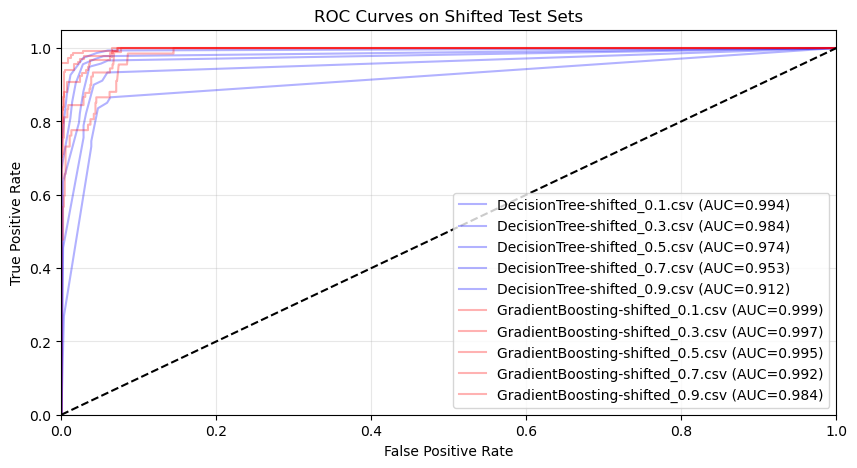


=== Evaluate Normal GBC vs. Adversarial GBC on Shifted Data ===

Shifted file: shifted_0.1.csv
  Normal GBC => Acc: 0.990, F1: 0.967, AUC: 0.999
  AdvTrain GBC => Acc: 0.992, F1: 0.973, AUC: 0.999
---------------------------------------------------
Shifted file: shifted_0.3.csv
  Normal GBC => Acc: 0.981, F1: 0.931, AUC: 0.997
  AdvTrain GBC => Acc: 0.987, F1: 0.952, AUC: 0.998
---------------------------------------------------
Shifted file: shifted_0.5.csv
  Normal GBC => Acc: 0.968, F1: 0.871, AUC: 0.995
  AdvTrain GBC => Acc: 0.982, F1: 0.923, AUC: 0.996
---------------------------------------------------
Shifted file: shifted_0.7.csv
  Normal GBC => Acc: 0.959, F1: 0.788, AUC: 0.991
  AdvTrain GBC => Acc: 0.977, F1: 0.869, AUC: 0.993
---------------------------------------------------
Shifted file: shifted_0.9.csv
  Normal GBC => Acc: 0.948, F1: 0.662, AUC: 0.983
  AdvTrain GBC => Acc: 0.971, F1: 0.779, AUC: 0.986
---------------------------------------------------
[Round 1] Vali

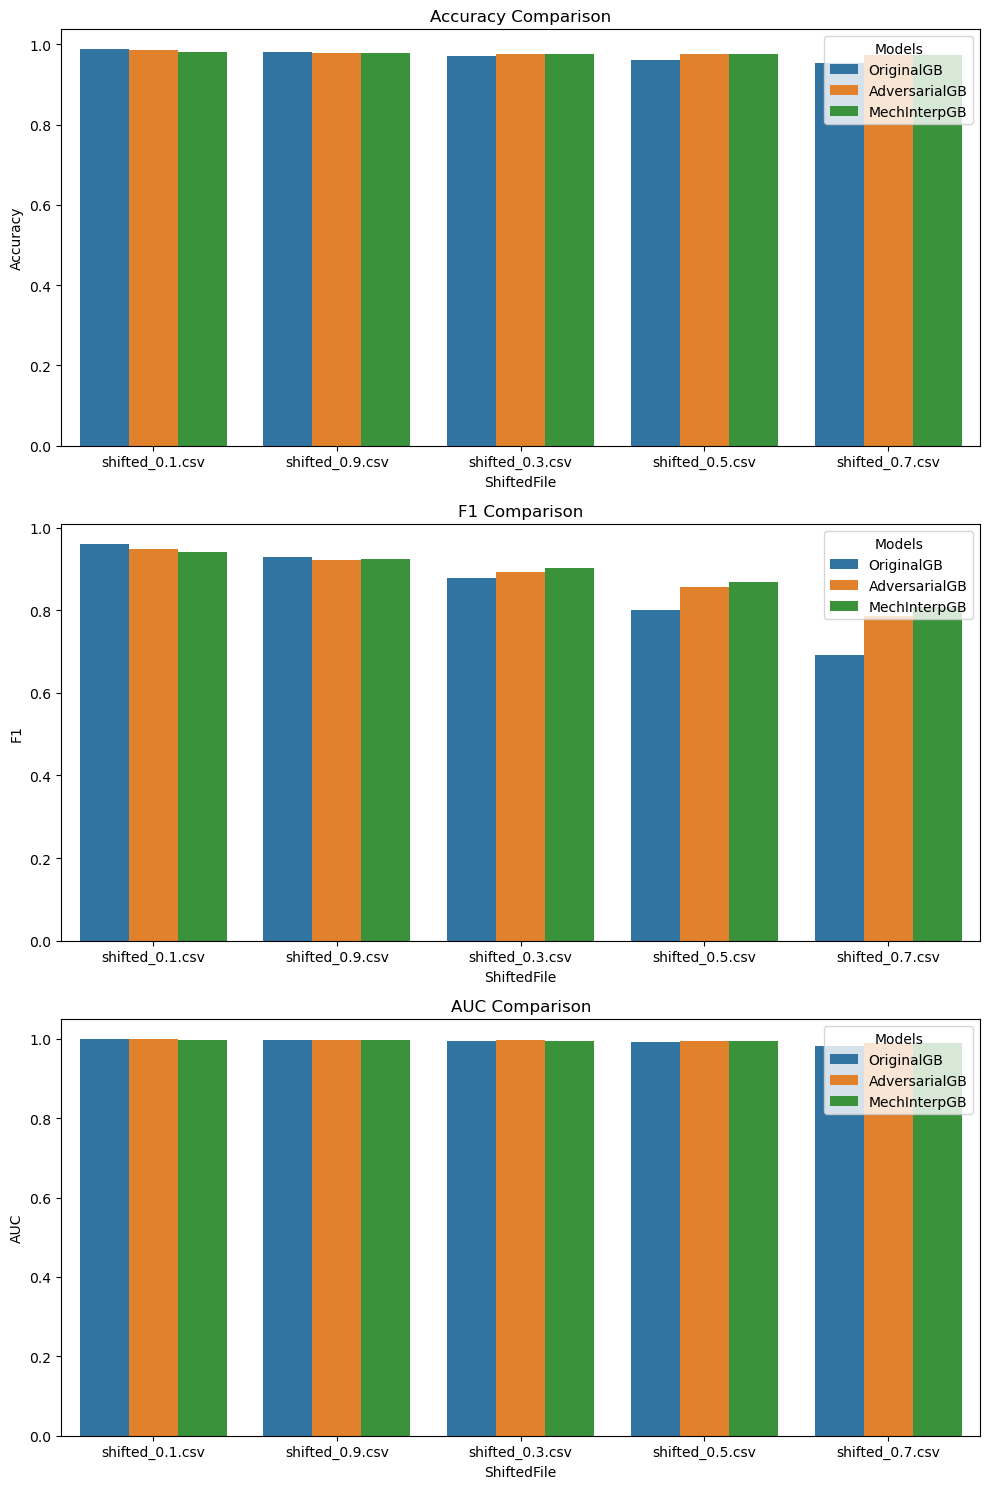

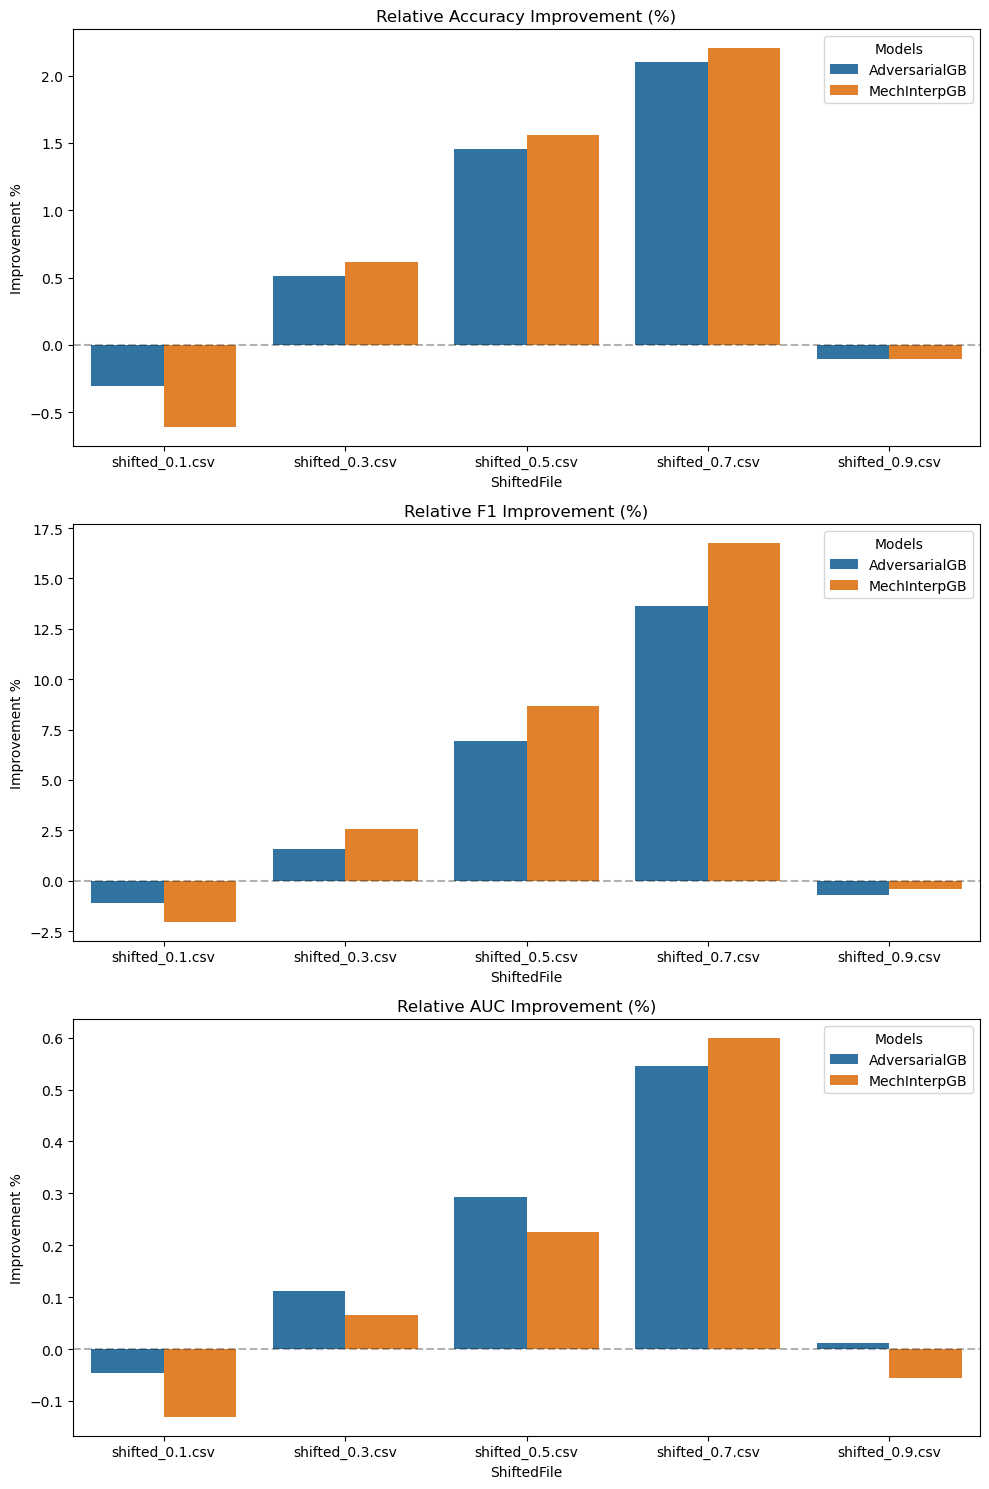

In [40]:
# 1) Generate data for n_features
create_shifted_datasets(n_features=4, output_folder="data", base_n_samples=1000, cov_scale=3.5, mean_shift_scale=2.5)

# 2) Visualize shifts
visualize_feature_shifts("data", features_to_plot=(0,1))

# 3) Evaluate baseline models
evaluate_models_on_shifts("data")

# 4) Compare adv vs normal
compare_adversarial_training("data")

# 5) Mechanistic robust boosting
demo_mechanistic_robust_boosting("data", n_rounds=1)

# 6) Compare all
compare_models_performance("data")


In [46]:
def tune_mechinterp_hparams(
    folder: str = "data_folder",
    base_shift_candidates = [0.05, 0.1, 0.2],
    fraction_candidates = [0.3, 0.5, 0.7],
    n_rounds: int = 3,
    final_train_size: int = None,
    random_state: int = 42
):
    """
    1. Load the original dataset from `folder`.
    2. Train baseline GB + Adversarial GB for reference.
    3. For each (base_shift_factor, fraction_to_shift) in the grid:
       - Train a MechInterp model.
       - Evaluate on the same shifted CSVs.
    4. Compare performance + Return a table of all results + Identify best combo.
    Parameters
    ----------
    folder : str
        Folder containing original.csv and shifted_*.csv.
    base_shift_candidates : list
        Values to try for `base_shift_factor`.
    fraction_candidates : list
        Values to try for `fraction_to_shift`.
    n_rounds : int
        Rounds of MechInterp training.
    final_train_size : int or None
        If not None, downsample final training set to keep dataset size fair.
    random_state : int
        For reproducibility.
    Returns
    -------
    pd.DataFrame
        A DataFrame summarizing all runs (Model, base_shift, fraction, ShiftFile, Accuracy, F1, AUC).
    (float, float)
        The best (base_shift_factor, fraction_to_shift) combo (based on chosen metric).
    """
    # 1) Load original => train data
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    if final_train_size is None:
        final_train_size = len(X_train)  # default to full training size
    # 2) Train baseline
    gbc_baseline = train_baseline_gb(
        X_train, y_train, 
        final_train_size=final_train_size, 
        random_state=random_state
    )
    # 2b) Train adversarial
    gbc_adv, X_adv, y_adv = adversarial_training_gbc(
        X_train, y_train,
        epsilon=0.1,
        max_rounds=3,
        fraction_to_perturb=0.5,
        final_train_size=final_train_size,
        random_state=random_state
    )
    # We'll evaluate on each shifted file
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
  
    # Collect all results in a list of dicts
    all_results = []
  
    # Evaluate Baseline + Adversarial once here
    model_dict = {
        "OriginalGB": gbc_baseline,
        "AdversarialGB": gbc_adv
    }
  
    for model_name, model_obj in model_dict.items():
        for test_file in test_files:
            df_test = pd.read_csv(os.path.join(folder, test_file))
            X_test = df_test[X_train.columns]
            y_test = df_test['target']
          
            y_pred = model_obj.predict(X_test)
            y_proba = model_obj.predict_proba(X_test)[:, 1]
          
            all_results.append({
                "Model": model_name,
                "BaseShiftFactor": None,
                "FractionShift": None,
                "ShiftedFile": test_file,
                "Accuracy": accuracy_score(y_test, y_pred),
                "F1": f1_score(y_test, y_pred),
                "AUC": roc_auc_score(y_test, y_proba)
            })
    # 3) For each combo of base_shift_factor, fraction_to_shift => train MechInterp
    for base_shift in base_shift_candidates:
        for fraction_shift in fraction_candidates:
            model_name_combo = f"MechInterp_s{base_shift}_f{fraction_shift}"
          
            # Train MechInterp
            gbc_mech, X_mech, y_mech = mech_interp_boosting(
                X_train, y_train,
                base_model=None,
                base_shift_factor=base_shift,
                n_rounds=n_rounds,
                fraction_to_shift=fraction_shift,
                min_improvement=0.001,
                noise_scale=0.01,
                n_features_to_shift=2,  # or your choice
                final_train_size=final_train_size,
                use_weighted_fit=True,
                random_state=random_state
            )
          
            # Evaluate on each shifted file
            for test_file in sorted(test_files):
                df_test = pd.read_csv(os.path.join(folder, test_file))
                X_test = df_test[X_train.columns]
                y_test = df_test['target']
              
                y_pred = gbc_mech.predict(X_test)
                y_proba = gbc_mech.predict_proba(X_test)[:, 1]
              
                all_results.append({
                    "Model": model_name_combo,
                    "BaseShiftFactor": base_shift,
                    "FractionShift": fraction_shift,
                    "ShiftedFile": test_file,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "F1": f1_score(y_test, y_pred),
                    "AUC": roc_auc_score(y_test, y_proba)
                })
    df_all = pd.DataFrame(all_results)
    # 4) Identify best combo:
    # Let's pick "best" as highest average AUC across all shifted files
    # (You can change to F1 or average of all metrics.)
    # Filter only rows with Model starting in "MechInterp_"
    df_mech = df_all[df_all["Model"].str.startswith("MechInterp_s")]
  
    # Group by (BaseShiftFactor, FractionShift), average the AUC
    grouped = df_mech.groupby(["BaseShiftFactor", "FractionShift"])["AUC"].mean().reset_index()
    best_row = grouped.loc[grouped["AUC"].idxmax()]  # row with highest mean AUC
    best_base_shift = best_row["BaseShiftFactor"]
    best_fraction = best_row["FractionShift"]
    best_auc = best_row["AUC"]
  
    print("\n======== MechInterp Hyperparam Tuning Results ========")
    print(df_mech.groupby(["BaseShiftFactor", "FractionShift"])[["Accuracy","F1","AUC"]].mean())
    print("======================================================\n")
    print(f"Best Combination (by avg AUC): base_shift={best_base_shift}, fraction={best_fraction}, AUC={best_auc:.3f}")
  
    return df_all, (best_base_shift, best_fraction)

In [47]:
# 1) Ensure data_folder has original.csv + shifted_*.csv
df_results, (best_bs, best_fr) = tune_mechinterp_hparams(
    folder="data",
    base_shift_candidates=[0.05, 0.1, 0.2],
    fraction_candidates=[0.3, 0.5, 0.7],
    n_rounds=3,
    final_train_size=None  # or a specific integer
)
print("\nFull Results:\n", df_results.head(20))
print(f"\nBest MechInterp Hyperparameters found: base_shift_factor={best_bs}, fraction_to_shift={best_fr}")


[Round 1] Validation Score = 0.975
  => Added 240 new shifted samples; total = 1040
[Round 2] Validation Score = 0.970
  => Added 312 new shifted samples; total = 1352
[Round 3] Validation Score = 0.965
  => Added 405 new shifted samples; total = 1757
[Round 1] Validation Score = 0.975
  => Added 400 new shifted samples; total = 1200
[Round 2] Validation Score = 0.975
  => Added 600 new shifted samples; total = 1800
[Round 3] Validation Score = 0.970
  => Added 900 new shifted samples; total = 2700
[Round 1] Validation Score = 0.975
  => Added 560 new shifted samples; total = 1360
[Round 2] Validation Score = 0.970
  => Added 951 new shifted samples; total = 2311
[Round 3] Validation Score = 0.970
  => Added 1617 new shifted samples; total = 3928
[Round 1] Validation Score = 0.975
  => Added 240 new shifted samples; total = 1040
[Round 2] Validation Score = 0.970
  => Added 312 new shifted samples; total = 1352
[Round 3] Validation Score = 0.965
  => Added 405 new shifted samples; tota